# Horizontal scaling of columnar analysis: Dask

(no frills notebook)

<br><br><br><br><br>

There are many ways to spread a computation to many processes or many machines—the most conventional way is to use a batch system.

[Coffea](https://coffeateam.github.io/coffea/) packages up a lot of what I'm about to show in a HEP-oriented framework. The next major version, based on dask-awkward, is [still in pre-release](https://pypi.org/project/coffea/#history) but will be in final release soon.

This notebook will focus on Dask and dask-awkward.

## Dask task graphs

In [ ]:
import dask

Eager Python code:

In [ ]:
def increment(i):
    return i + 1

def add(a, b):
    return a + b

a, b = 1, 12
c = increment(a)
d = increment(b)
output = add(c, d)

output

Lazy Python code:

In [ ]:
@dask.delayed
def increment(i):
    return i + 1

@dask.delayed
def add(a, b):
    return a + b

a, b = 1, 12
c = increment(a)
d = increment(b)
output = add(c, d)

output

In [ ]:
output.visualize()

In [ ]:
output.compute()

<br><br><br><br><br>

## Distributed computing

A delayed computation is a set of instructions to run it, which we can send to remote computers to run it remotely.

When we break up a large computation, send it to many computers, and collect the results, we have distributed the computation.

In [ ]:
import time

@dask.delayed
def start():
    print("start")
    return 1

@dask.delayed
def concurrent(initial, i):
    time.sleep(0.5)
    print(f"concurrent {i}")
    return initial + i**2

@dask.delayed
def combine(partial_results):
    print("combine")
    return sum(partial_results)

initial = start()
output = combine([concurrent(initial, i) for i in range(10)])

In [ ]:
output.visualize()

The `dask` library has three built-in schedulers:

- `"synchronous"`: not parallel (for debugging)
- `"threads"`: multiple threads in the same process, limited by the [Python GIL](https://realpython.com/python-gil/)
- `"processes"`: multiple Python processes; not affected by the GIL, but it has to start a bunch of processes

In [ ]:
with dask.config.set(scheduler="synchronous"):
    output.compute()

Dask `distributed` is another library that focuses on distributed computing.

<img src="img/distributed-overview.svg" width="100%">

Run in separate terminals:

```bash
dask-scheduler
```

and several of the following:

```bash
dask-worker --nthreads 1 127.0.0.1:8786
```

In [ ]:
import dask.distributed

client = dask.distributed.Client("127.0.0.1:8786")
client

In [ ]:
output.compute()

<br><br><br><br><br>

## Dask collections

You can build general computations with `@dask.delayed`, but there are some common patterns that we'd want to build all the time.

For instance, splitting a calculation on NumPy arrays into embarrassingly parallel parts:

In [ ]:
import numpy as np

In [ ]:
@dask.delayed
def quadratic_formula(a, b, c):
    return (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

@dask.delayed
def combine_results(parts):
    return np.concatenate(parts)

In [ ]:
parts = []

for i in range(10):
    a = np.random.uniform(5, 10, 1000000)
    b = np.random.uniform(10, 20, 1000000)
    c = np.random.uniform(-0.1, 0.1, 1000000)
    parts.append({"a": a, "b": b, "c": c})

In [ ]:
output = combine_results(
    [quadratic_formula(part["a"], part["b"], part["c"]) for part in parts]
)

In [ ]:
output.visualize()

In [ ]:
output.compute()

<br><br><br><br><br>

Handling all of those parts is annoying. Without splitting and parallelizing, this would be:

In [ ]:
def quadratic_formula(a, b, c):
    return (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

a = np.random.uniform(5, 10, 1000000 * 10)
b = np.random.uniform(10, 20, 1000000 * 10)
c = np.random.uniform(-0.1, 0.1, 1000000 * 10)

output = quadratic_formula(a, b, c)
output

Wouldn't it be nice to just say

In [ ]:
import dask.array as da

a = da.random.uniform(5, 10, 1000000 * 10, chunks=1000000)
b = da.random.uniform(10, 20, 1000000 * 10, chunks=1000000)
c = da.random.uniform(-0.1, 0.1, 1000000 * 10, chunks=1000000)

output = quadratic_formula(a, b, c)
output

In [ ]:
output.visualize(optimize_graph=True)

In [ ]:
output.compute()

Or more complex examples:

In [ ]:
reduced_output = np.sum(output)
reduced_output.visualize(optimize_graph=True)

In [ ]:
reduced_output.compute()

<br><br><br><br><br>

<img src="img/dask-overview.svg" width="100%">

<br><br><br><br><br>

## dask-awkward

[dask-awkward](https://github.com/dask-contrib/dask-awkward) is a new high-level collection type for distributed Awkward Arrays.

Presentations and demos:

- Mar 28, 2022 [IRIS-HEP topical meeting](https://indico.cern.ch/event/1140959/#6-awkward-arrays-in-dask)
- Sep 16, 2022 [PyHEP workshop](https://indico.cern.ch/event/1150631/timetable/#37-dask-tutorial)
- Dec 2, 2022 [PyData Global](https://global2022.pydata.org/cfp/talk/GEHBLR/)
- Dec 14, 2022 [Anaconda webinar](http://go2.anaconda.com/Mzg3LVhOVy02ODgAAAGIc7AHDk0j1xApwNgUgP5mf9m2SWAdc5ADKi_FOU9HRFu-6RL4CAXZDmoT3YWfjF68m4h2DUM=)
- Apr 10, 2023 [Doug Davis's blog](https://ddavis.io/blog/dask-awkward-optimization/)

In [1]:
import dask_awkward as dak

In [2]:
lazy_events = dak.from_parquet("data/SMHiggsToZZTo4L.parquet")
lazy_events

dask.awkward<from-parquet, npartitions=1>

In [3]:
lazy_events.type.show()

?? * {
    run: int32,
    luminosityBlock: int64,
    event: uint64,
    PV: Vector3D[
        x: float32,
        y: float32,
        z: float32
    ],
    electron: var * Momentum4D[
        pt: float32,
        eta: float32,
        phi: float32,
        mass: float32,
        charge: int32,
        pfRelIso03_all: float32,
        dxy: float32,
        dxyErr: float32,
        dz: float32,
        dzErr: float32
    ],
    muon: var * Momentum4D[
        pt: float32,
        eta: float32,
        phi: float32,
        mass: float32,
        charge: int32,
        pfRelIso03_all: float32,
        pfRelIso04_all: float32,
        dxy: float32,
        dxyErr: float32,
        dz: float32,
        dzErr: float32
    ],
    MET: Momentum2D[
        pt: float32,
        phi: float32
    ]
}


In [4]:
import uproot

In [5]:
lazy_tree = uproot.dask("data/SMHiggsToZZTo4L.root", step_size="10 MB")
lazy_tree

dask.awkward<from-uproot, npartitions=5>

In [6]:
lazy_tree.type.show()

?? * {
    run: int32,
    luminosityBlock: uint32,
    event: uint64,
    PV_npvs: int32,
    PV_x: float32,
    PV_y: float32,
    PV_z: float32,
    nMuon: uint32,
    Muon_pt: var * float32,
    Muon_eta: var * float32,
    Muon_phi: var * float32,
    Muon_mass: var * float32,
    Muon_charge: var * int32,
    Muon_pfRelIso03_all: var * float32,
    Muon_pfRelIso04_all: var * float32,
    Muon_dxy: var * float32,
    Muon_dxyErr: var * float32,
    Muon_dz: var * float32,
    Muon_dzErr: var * float32,
    nElectron: uint32,
    Electron_pt: var * float32,
    Electron_eta: var * float32,
    Electron_phi: var * float32,
    Electron_mass: var * float32,
    Electron_charge: var * int32,
    Electron_pfRelIso03_all: var * float32,
    Electron_dxy: var * float32,
    Electron_dxyErr: var * float32,
    Electron_dz: var * float32,
    Electron_dzErr: var * float32,
    MET_pt: float32,
    MET_phi: float32
}


In [7]:
lazy_events2 = lazy_events.repartition(5)

In [8]:
import numpy as np

def fast_mass(mu1pt, mu2pt, mu1eta, mu2eta, mu1phi, mu2phi):
    return np.sqrt(
        2 * mu1pt * mu2pt * (np.cosh(mu1eta - mu2eta) - np.cos(mu1phi - mu2phi))
    )

muplus = lazy_events2.muon[lazy_events2.muon.charge > 0]
muminus = lazy_events2.muon[lazy_events2.muon.charge < 0]

mu1, mu2 = dak.unzip(dak.cartesian((muplus, muminus)))

output = fast_mass(mu1.pt, mu2.pt, mu1.eta, mu2.eta, mu1.phi, mu2.phi)

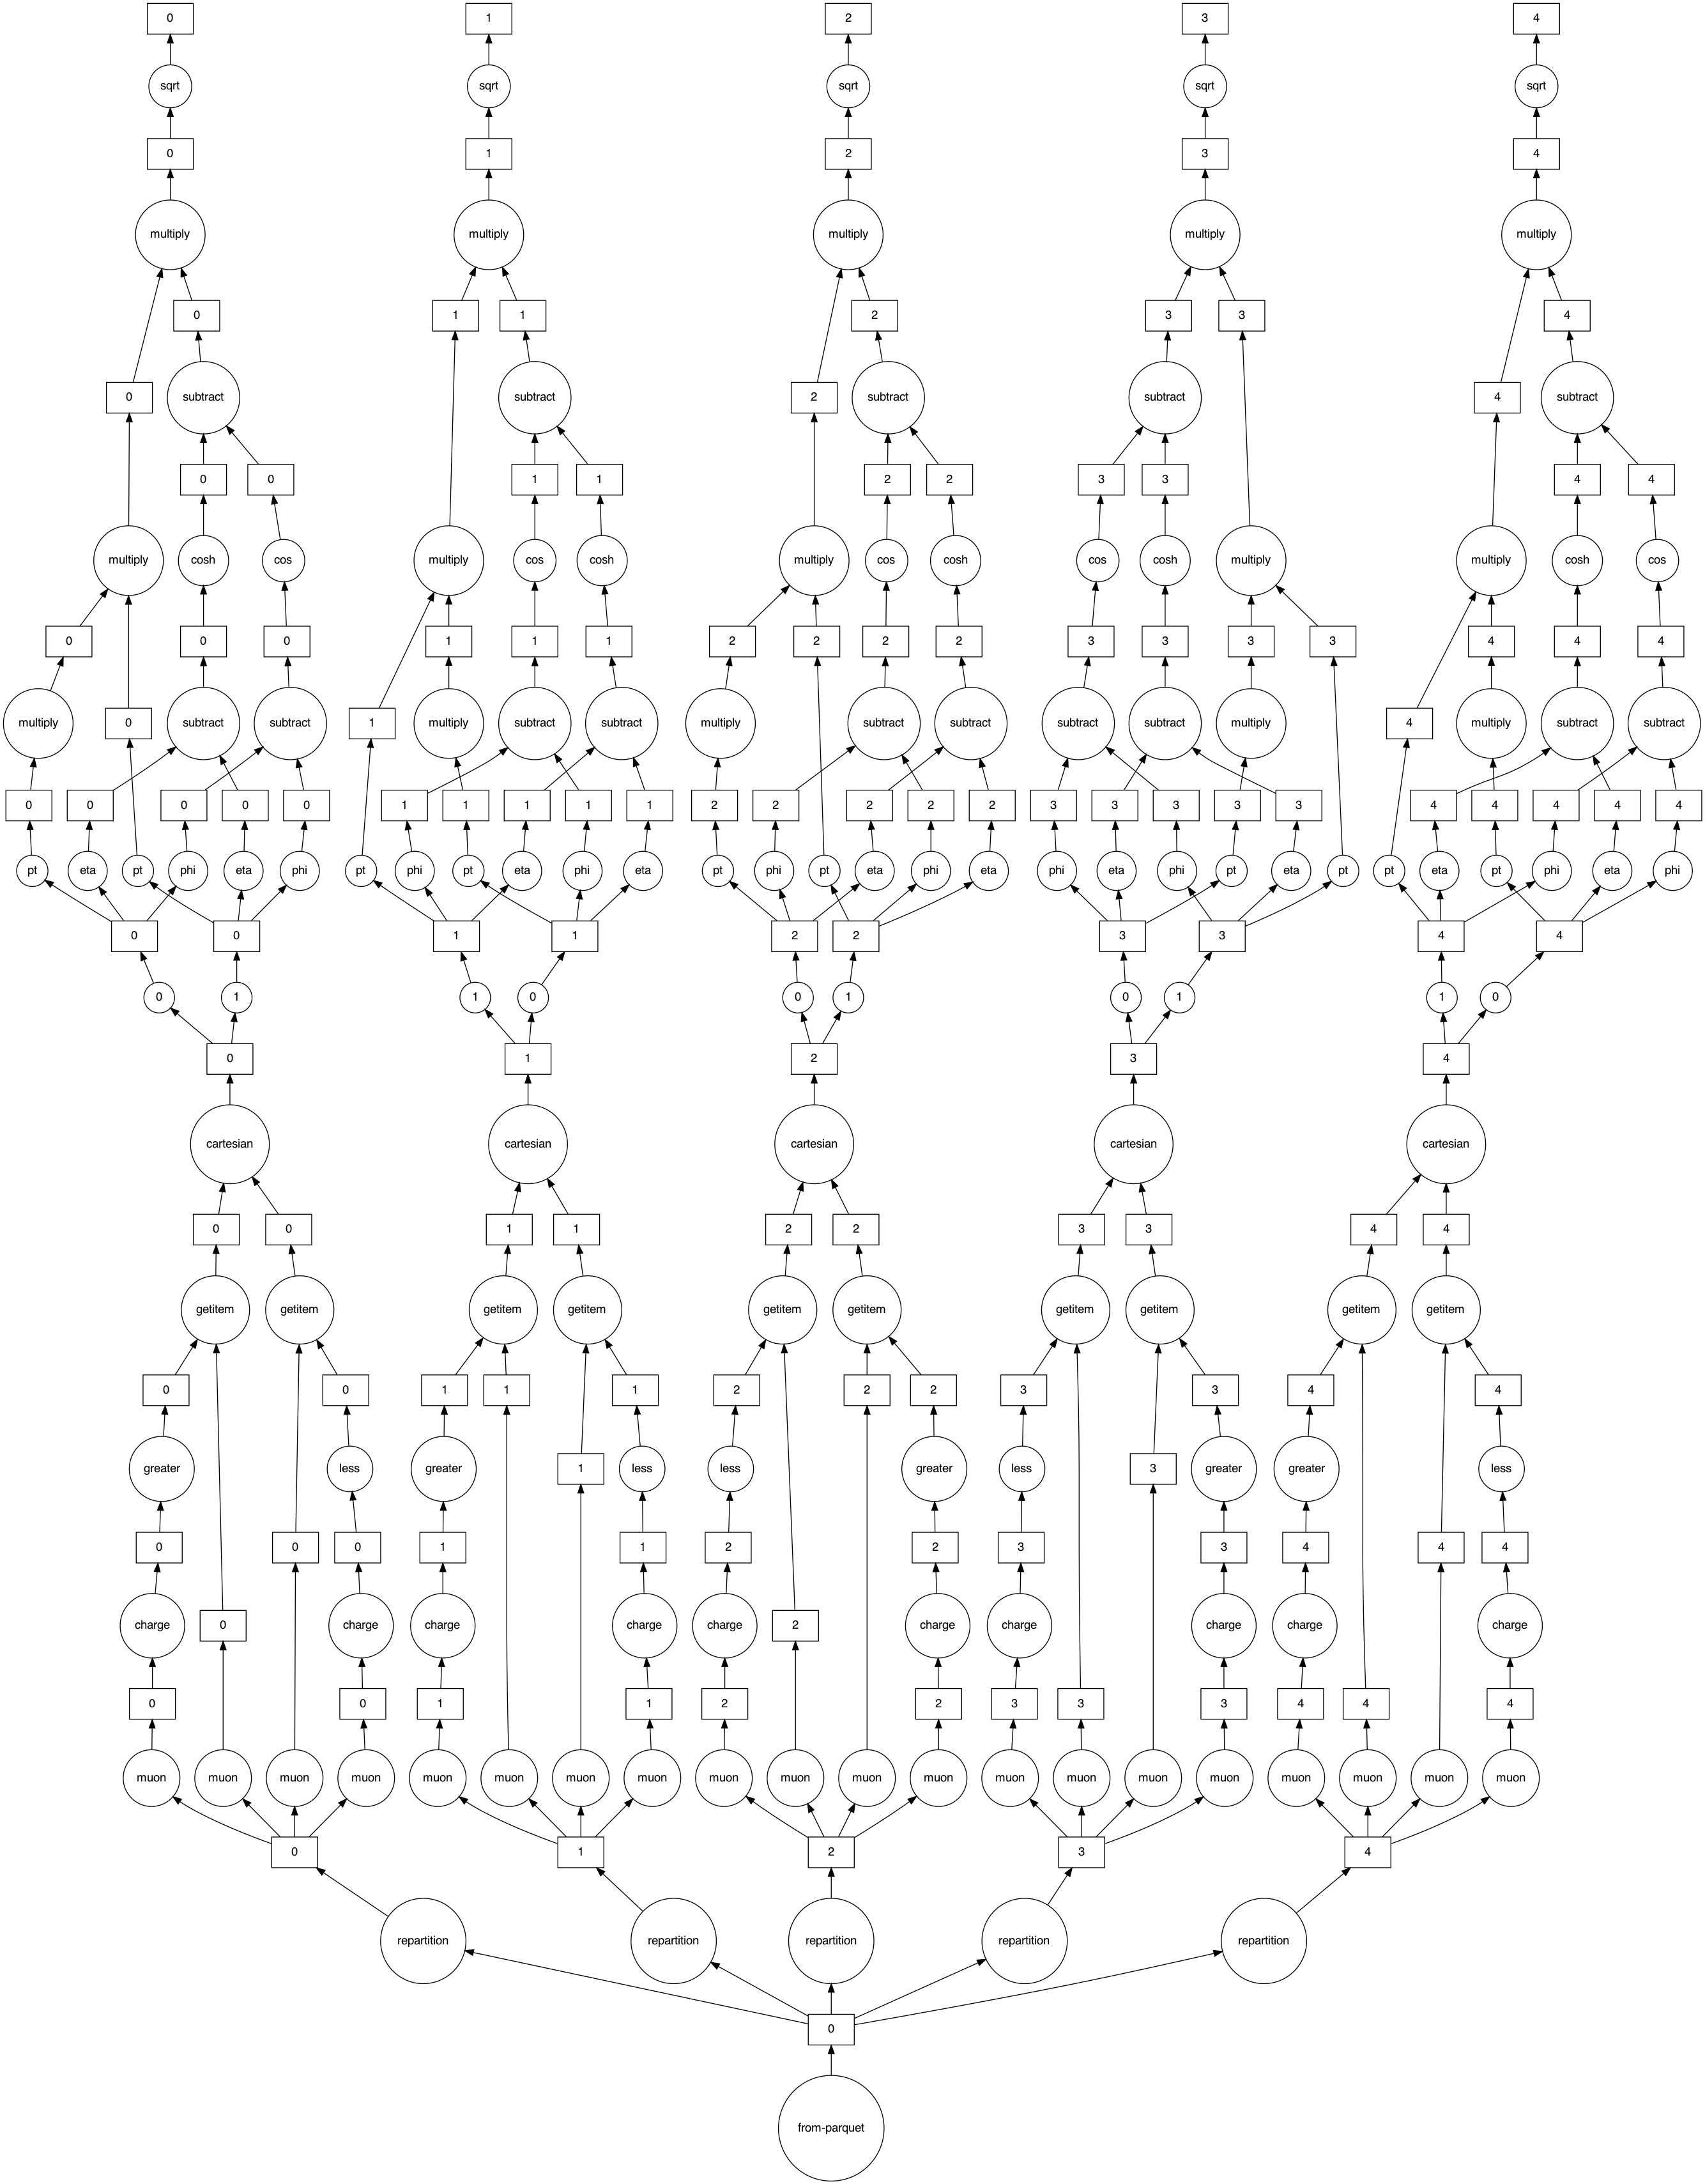

In [11]:
output.visualize()

In [18]:
from dask.distributed import Client

client = Client()
client

/Users/jpivarski/mambaforge/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55354 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:55354/status,
Dashboard: http://127.0.0.1:55354/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55355,Workers: 4
Dashboard: http://127.0.0.1:55354/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:55369,Total threads: 2
Dashboard: http://127.0.0.1:55373/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:55358,


In [20]:
output.compute()

<Array [[89.5, 22.5], [], [], ..., [], []] type='299973 * var * ?float32'>